# Learning data

In [1]:
import importlib
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import learning_utils
import visualization_utils

## Preprocessing

In [2]:
importlib.reload(sys.modules['visualization_utils'])
from visualization_utils import barplot

In [3]:
with open('data/loanword_data.json', 'r') as f:
    loanword_data = json.load(f)
with open('data/armenian_data.json', 'r') as f:
    armenian_data = json.load(f)

# for convenience
for i in range(len(armenian_data)):
    armenian_data[i]['langs'] = ['հայերեն']

We identify պարսկերեն with պահլավերեն, as well as տաճկերեն with թուրքերեն:

In [4]:
for datum in loanword_data:
    for i in range(len(datum['langs'])):
        if datum['langs'][i] == 'պահլավերեն':
            datum['langs'][i] = 'պարսկերեն'
        elif datum['langs'][i] == 'տաճկերեն':
            datum['langs'][i] = 'թուրքերեն'
    datum['langs'] = list(set(datum['langs']))

In [5]:
def get_lang_counts(loanword_data, armenian_data):
    lang_counts = {}
    for datum in loanword_data:
        for lang in datum['langs']:
            if lang in lang_counts.keys():
                lang_counts[lang] += 1
            else:
                lang_counts[lang] = 1
    lang_counts['հայերեն'] = len(armenian_data)
    lang_counts = sorted(lang_counts.items(), key=lambda x: -x[1])
    return lang_counts

In [6]:
lang_counts = get_lang_counts(loanword_data, armenian_data)

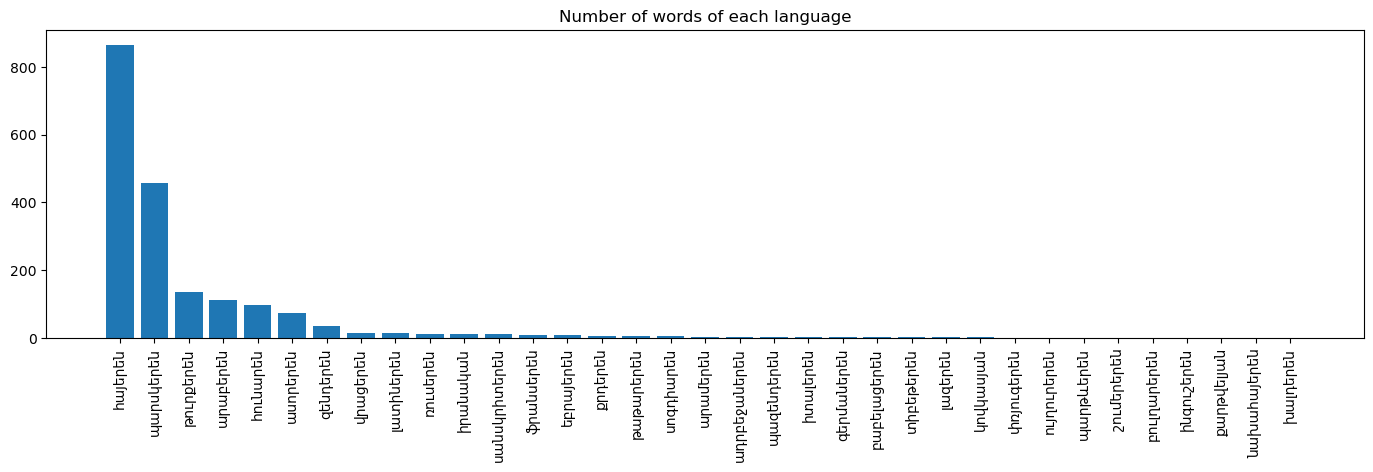

In [7]:
barplot(lang_counts, 'Number of words of each language')

Since the majority of languages have only a few words in our dataset we will consider only some languages:

In [8]:
important_langs = ['հայերեն', 'պարսկերեն', 'թուրքերեն', 'արաբերեն', 'հունարեն', 'ասորերեն']

In [9]:
for datum in loanword_data:
    for i in reversed(range(len(datum['langs']))):
        if datum['langs'][i] not in important_langs[1:]:
            del datum['langs'][i]

for i in reversed(range(len(loanword_data))):
    if len(loanword_data[i]['langs']) == 0:
        del loanword_data[i]

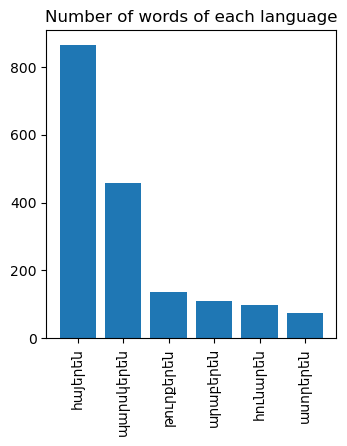

In [10]:
lang_counts = get_lang_counts(loanword_data, armenian_data)
barplot(lang_counts, 'Number of words of each language')

In [11]:
data = [*loanword_data, *armenian_data]
len(data)

1653

In [12]:
all_langs = set(important_langs)
lang2idx = {lang: i for i, lang in enumerate(sorted(all_langs))}
idx2lang = {i: lang for lang, i in lang2idx.items()}

In [13]:
def encode_langs(langs):
    vec = np.zeros(len(lang2idx), dtype=int)
    for lang in langs:
        vec[lang2idx[lang]] = 1
    return vec

Y = np.array([encode_langs(item['langs']) for item in data])

## scikit-learn (LogisticRegression)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import ColumnTransformer

importlib.reload(sys.modules['learning_utils'])
from learning_utils import multi_label_train_test_split, label_distribution

### Using only syllables as features

In [15]:
syllable_strings = [' '.join(item['syllables']) for item in data]

vectorizer = CountVectorizer(analyzer="word")  # treat syllables as tokens
X = vectorizer.fit_transform(syllable_strings)

In [16]:
clf = OneVsRestClassifier(LogisticRegression(max_iter=200))

In [17]:
X_train, X_test, Y_train, Y_test = multi_label_train_test_split(X, Y)

In [18]:
print("Train distribution:", label_distribution(Y_train))
print("Test distribution:", label_distribution(Y_test))

Train distribution: [0.04466313 0.0673732  0.08327025 0.52384557 0.05904618 0.27706283]
Test distribution: [0.04518072 0.06626506 0.0813253  0.52108434 0.05722892 0.27710843]


In [19]:
clf.fit(X_train, Y_train)

,estimator,LogisticRegre...(max_iter=200)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


In [20]:
pred = clf.predict(X[:5])
print(pred)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [21]:
def decode_langs(vec):
    return [idx2lang[i] for i, v in enumerate(vec) if v == 1]

print(decode_langs(pred[0]))

[]


In [22]:
preds = clf.predict(X_test)

In [23]:
def display_metrics(Y_test, preds):
    print("Micro-F1:", f1_score(Y_test, preds, average="micro"))
    print("Macro-F1:", f1_score(Y_test, preds, average="macro"))

In [24]:
display_metrics(Y_test, preds)

Micro-F1: 0.5709515859766278
Macro-F1: 0.1792241379310345


Micro-F1 score shows that our model has actually learned something, so syllable distributions indeed matter. The low value of Macro-F1 score is explained by the class imbalance.

### Incorporating letter features

In [25]:
# syllable representation
syllable_strings = [' '.join(item['syllables']) for item in data]
# letter (character-level) representation
word_strings = [item['word'] for item in data]

In [26]:
X = pd.DataFrame({
    "syllables": syllable_strings,
    "word": word_strings
})

combined_features = ColumnTransformer([
    ("syllables", CountVectorizer(analyzer="word"), "syllables"),
    ("chars", CountVectorizer(analyzer="char", ngram_range=(1,3)), "word"),
])

clf = Pipeline([
    ("features", combined_features),
    ("clf", OneVsRestClassifier(LogisticRegression(max_iter=200)))
])

In [27]:
X_train, X_test, Y_train, Y_test = multi_label_train_test_split(X, Y)

print("Train distribution:", label_distribution(Y_train))
print("Test distribution:", label_distribution(Y_test))

Train distribution: [0.04466313 0.0673732  0.08327025 0.52384557 0.05904618 0.27706283]
Test distribution: [0.04518072 0.06626506 0.0813253  0.52108434 0.05722892 0.27710843]


In [28]:
clf.fit(X_train, Y_train)

,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('syllables', ...), ('chars', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
pred = clf.predict(X[:5])
print(pred)
print(decode_langs(pred[0]))

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 1]
 [0 0 0 0 0 1]]
['ասորերեն']


In [30]:
preds = clf.predict(X_test)

display_metrics(Y_test, preds)

Micro-F1: 0.6517571884984026
Macro-F1: 0.3348188862880796


Obviously incorporating letter features helped dramatically boost model's performance from 0.57 to 0.65 Micro-F1 score.

### Applying byte-pair encoding

In [31]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

In [32]:
# Initialize a BPE model
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Train it on your dataset
trainer = trainers.BpeTrainer(vocab_size=2500, min_frequency=2, special_tokens=["[PAD]", "[UNK]"])
word_list = [item["word"] for item in data]

tokenizer.train_from_iterator(word_list, trainer)

# Save to reuse later
tokenizer.save("data/armenian_bpe.json")

In [33]:
# reload
tokenizer = Tokenizer.from_file("data/armenian_bpe.json")

# encode words
bpe_encoded = [tokenizer.encode(w).tokens for w in word_list]
print(bpe_encoded[:5])

[['աբ', 'եղ', 'ա'], ['ադ', 'աթ'], ['ադամ', 'անդ'], ['ազ', 'ապ'], ['ազատ']]


In [34]:
bpe_strings = [" ".join(tokens) for tokens in bpe_encoded]

In [35]:
features = ColumnTransformer([
    ("syllables", CountVectorizer(analyzer="word"), "syllables"),
    ("chars", CountVectorizer(analyzer="char", ngram_range=(1,3)), "word"),
    ("bpe", TfidfVectorizer(analyzer="word"), "bpe"),
])

clf = Pipeline([
    ("features", features),
    ("clf", OneVsRestClassifier(LogisticRegression(max_iter=200)))
])

In [36]:
X = pd.DataFrame({
    "word": word_list,
    "syllables": [" ".join(item["syllables"]) for item in data],
    "bpe": bpe_strings
})

X_train, X_test, Y_train, Y_test = multi_label_train_test_split(X, Y)

In [37]:
clf.fit(X_train, Y_train)

,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('syllables', ...), ('chars', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [38]:
preds = clf.predict(X_test)

display_metrics(Y_test, preds)

Micro-F1: 0.6561014263074485
Macro-F1: 0.34460311074402367


As we see adding byte-pair encoding helped to slightly improve model's accuracy from 0.652 to 0.656 Micro-F1 score.

### Optimizing hyperparameters

In [39]:
importlib.reload(sys.modules['learning_utils'])
from learning_utils import multi_label_train_val_test_split, optimize_model

In [40]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = multi_label_train_val_test_split(X, Y)

In [41]:
def lr_param_space(trial):
    return {
        "C": trial.suggest_float("C", 1e-3, 1e2, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l2"]),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "max_iter": trial.suggest_int("max_iter", 800, 3000, step=200),
    }

study = optimize_model(LogisticRegression, lr_param_space, X_val, Y_val, features, n_trials=30, random_state=24)

[I 2025-09-28 13:35:50,817] A new study created in memory with name: no-name-de4f9f7f-7b93-49d6-b84d-666ffb09dde5
[I 2025-09-28 13:35:52,542] Trial 0 finished with value: 0.5734959349593497 and parameters: {'C': 63.108305128599206, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 1200}. Best is trial 0 with value: 0.5734959349593497.
/home/saroyr/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/saroyr/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/saroyr/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/saroyr/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_ite

In [42]:
def display_best_params(study):
    print("Best params:", study.best_params)
    print("Best CV score:", study.best_value)

In [43]:
display_best_params(study)

Best params: {'C': 0.4116789457307348, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 2400}
Best CV score: 0.6036846853494077


In [44]:
log_regressor = LogisticRegression(**study.best_params)

clf = Pipeline([
    ("features", features),
    ("clf", OneVsRestClassifier(log_regressor))
])

clf.fit(X_train, Y_train)

,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('syllables', ...), ('chars', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
preds = clf.predict(X_test)

display_metrics(Y_test, preds)

Micro-F1: 0.6422628951747088
Macro-F1: 0.27433819163658446


Interestingly the cross validated model behaves more poorly on our dataset, than the non-cross validated one.

### Inspecting feature importances

In [46]:
importlib.reload(sys.modules['visualization_utils'])
from visualization_utils import bar_subplots

In [47]:
def get_all_features(pipe: Pipeline):
    feature_list = []
    for feature, transformer in pipe.named_steps['features'].named_transformers_.items():
        feature_list.append(transformer.get_feature_names_out())
    return np.concatenate(feature_list)

In [48]:
def _feature_vals(clf):
    if isinstance(clf, LogisticRegression):
        return clf.coef_
    if isinstance(clf, RandomForestClassifier):
        return clf.feature_importances_
    raise TypeError("clf is of unsupported type.")

def get_feature_vals(pipe: Pipeline):        
    # The OneVsRestClassifier
    ovr = pipe.named_steps["clf"]
    # The individual classifiers, one per language
    estimators = ovr.estimators_
    feature_vals = np.vstack([_feature_vals(est) for est in estimators]) # shape: (num_languages, num_features)
    return feature_vals

In [49]:
def top_features_for_class(class_idx, features_names, feature_vals, top_n=10):
    val = feature_vals[class_idx]
    top_pos = np.argsort(val)[-top_n:]      # largest positive
    top_neg = np.argsort(val)[:top_n]       # largest negative
    return {
        "language": idx2lang[class_idx],
        "top_positive": [(features_names[i], val[i]) for i in top_pos[::-1]],
        "top_negative": [(features_names[i], val[i]) for i in top_neg]
    }

def get_lang_infos(pipe):
    all_features = get_all_features(pipe)
    all_vals = get_feature_vals(pipe)
    lang_infos = [
        tuple(top_features_for_class(i, all_features, all_vals).values()) for i in range(len(idx2lang))
    ]
    return lang_infos

In [50]:
lang_infos = get_lang_infos(clf)

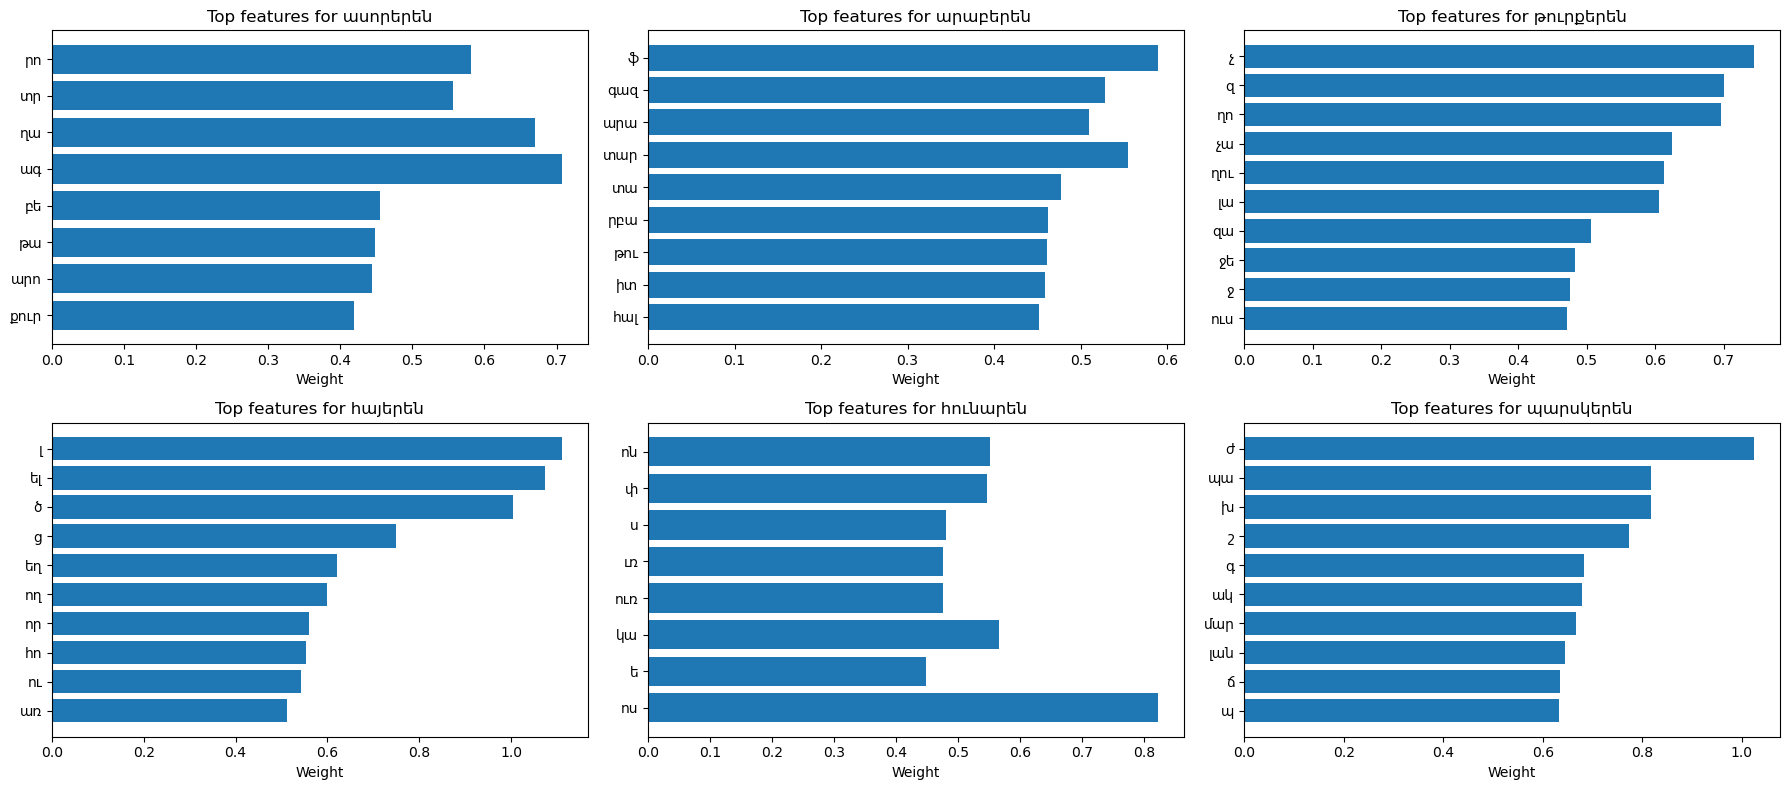

In [51]:
bar_subplots(lang_infos, xlabel='Weight')

ք dominates in ասորերեն.

խ and ֆ are dominant in արաբերեն.

չ and ղ are prevalent in թուրքերեն, according with our guess in the exploration notebook. 

As we see the top three features of հայերեն contain ել and լ, which is in fact the consequence of some verbs being present in the Armenian dataset. If we ignore this, ծ is the most important feature of Armenian words.

ո comes across often in հունարեն.

ժ and ճ are definitive indicators of պարսկերեն, as we had already noted in our exploration notebook.

## scikit-learn (RandomForestClassifier)

### Fitting on syllable + letter + BPE features

In [52]:
X = pd.DataFrame({
    "word": word_list,
    "syllables": syllable_strings,
    "bpe": bpe_strings
})

features = ColumnTransformer([
    ("syllables", CountVectorizer(analyzer="word", min_df=2), "syllables"),
    ("chars", CountVectorizer(analyzer="char", ngram_range=(1,3), min_df=2), "word"),
    ("bpe", TfidfVectorizer(analyzer="word", min_df=2), "bpe"),
])

In [53]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",   # helps with label imbalance inside each binary problem
    random_state=42
)

pipeline = Pipeline([
    ("features", features),
    ("clf", OneVsRestClassifier(rf, n_jobs= -1))
])

In [54]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = multi_label_train_val_test_split(X, Y)

In [55]:
pipeline.fit(X_train, Y_train)

,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('syllables', ...), ('chars', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [56]:
preds = pipeline.predict(X_test)

display_metrics(Y_test, preds)

Micro-F1: 0.6254180602006689
Macro-F1: 0.2354145259148237


### Optimizing hyperparameters

In [57]:
def rf_param_space(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

study = optimize_model(RandomForestClassifier, rf_param_space, X_val, Y_val, features, n_trials=25, random_state=33)

display_best_params(study)

[I 2025-09-28 13:36:03,263] A new study created in memory with name: no-name-964e8306-bff4-4611-864a-37ad6c2ce5c2
[I 2025-09-28 13:36:04,875] Trial 0 finished with value: 0.5863931048550457 and parameters: {'n_estimators': 112, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5863931048550457.
[I 2025-09-28 13:36:08,914] Trial 1 finished with value: 0.5151896005927123 and parameters: {'n_estimators': 289, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5863931048550457.
[I 2025-09-28 13:36:10,307] Trial 2 finished with value: 0.5652965836720906 and parameters: {'n_estimators': 91, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.5863931048550457.
[I 2025-09-28 13:36:11,934] Trial 3 finished with value: 0.5509971509971511 and parameters: {'n_estimators': 112, 'max_depth': 33, 'min

Best params: {'n_estimators': 164, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best CV score: 0.6120838807405972


In [58]:
rf = RandomForestClassifier(
    **study.best_params,
    n_jobs=-1,
    class_weight="balanced",   # helps with label imbalance inside each binary problem
    random_state=42
)

pipeline = Pipeline([
    ("features", features),
    ("clf", OneVsRestClassifier(rf, n_jobs= -1))
])

pipeline.fit(X_train, Y_train)

,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('syllables', ...), ('chars', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [59]:
preds = pipeline.predict(X_test)

display_metrics(Y_test, preds)

Micro-F1: 0.6686478454680534
Macro-F1: 0.3908276146272394


As we see cross validation raised model's accuracy from 0.63 to 0.67 Micro-F1 score. This model outperforms the one with logistic regression.

### Inspecting feature importances

In [60]:
lang_infos = get_lang_infos(pipeline)

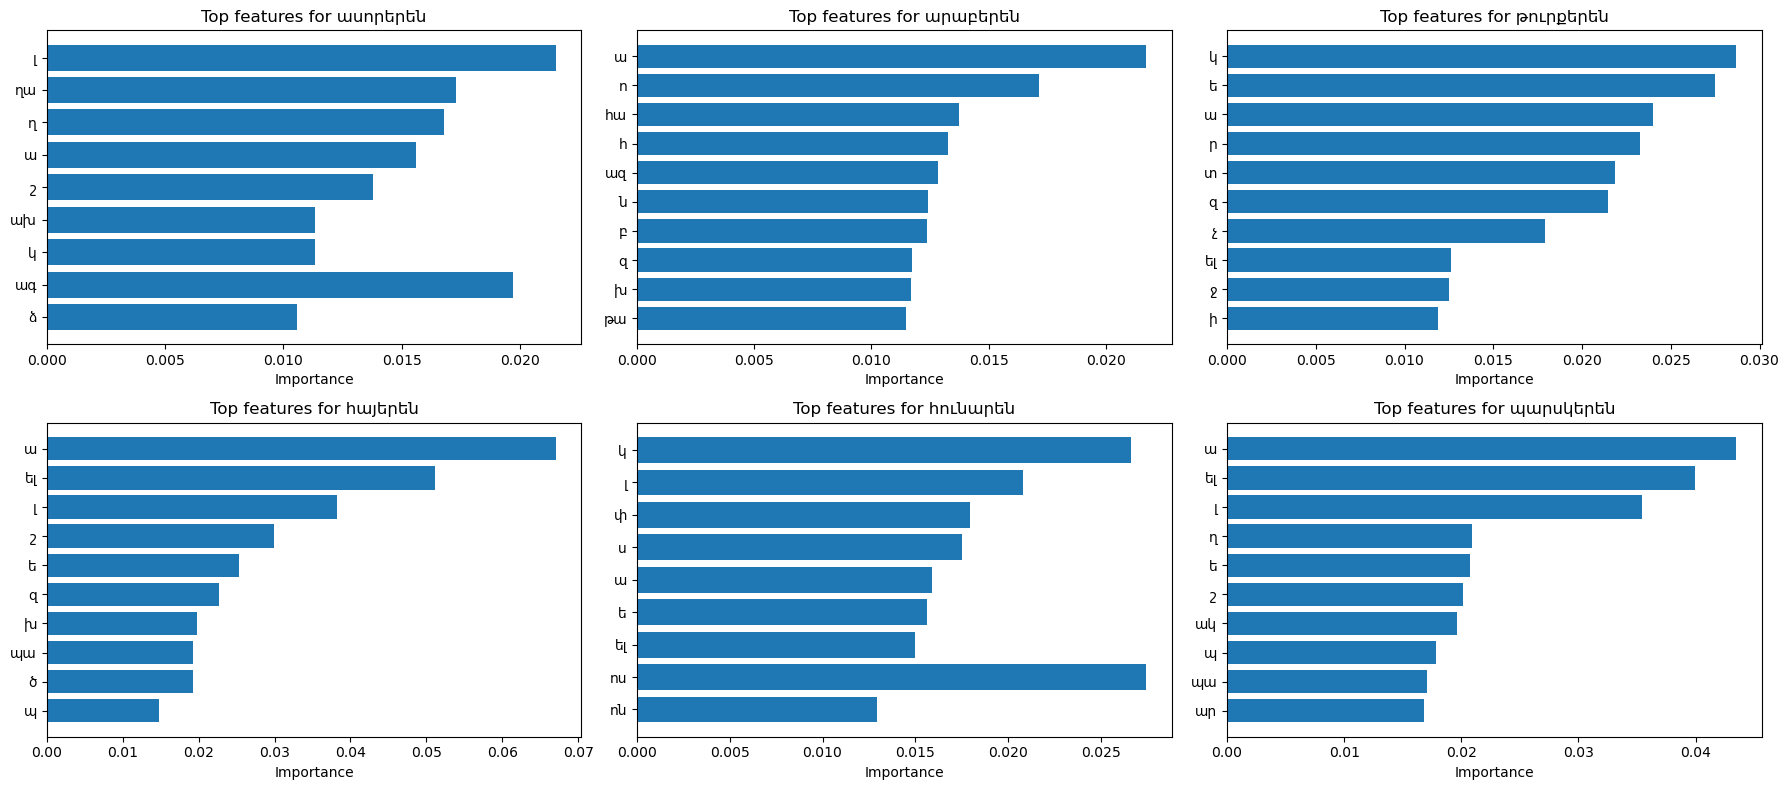

In [61]:
bar_subplots(lang_infos, xlabel='Importance')

## scikit-learn + CatBoost (with reduced features)

In [62]:
from catboost import CatBoostClassifier
from sklearn.decomposition import TruncatedSVD

### Fitting the model

In [63]:
reduced_features = Pipeline([
    ("features", features),  # defined above
    ("svd", TruncatedSVD(n_components=200, random_state=42))
])

cat = CatBoostClassifier(
    iterations=30,
    depth=8,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="F1",
    verbose=20,
    random_seed=42
)

clf = Pipeline([
    ("features", reduced_features),
    ("clf", OneVsRestClassifier(cat))
])

In [64]:
X_train, X_test, Y_train, Y_test = multi_label_train_test_split(X, Y)

In [65]:
clf.fit(X_train, Y_train)

0:	learn: 0.0333333	total: 185ms	remaining: 5.36s
20:	learn: 0.0333333	total: 1.41s	remaining: 604ms
29:	learn: 0.3380282	total: 1.96s	remaining: 0us
0:	learn: 0.0222222	total: 64.1ms	remaining: 1.86s
20:	learn: 0.1836735	total: 1.32s	remaining: 566ms
29:	learn: 0.4786325	total: 1.89s	remaining: 0us
0:	learn: 0.0530973	total: 62.1ms	remaining: 1.8s
20:	learn: 0.2677165	total: 1.32s	remaining: 565ms
29:	learn: 0.6075949	total: 1.87s	remaining: 0us
0:	learn: 0.7004082	total: 68.1ms	remaining: 1.97s
20:	learn: 0.9420904	total: 1.23s	remaining: 527ms
29:	learn: 0.9716714	total: 1.78s	remaining: 0us
0:	learn: 0.0975610	total: 57.6ms	remaining: 1.67s
20:	learn: 0.2471910	total: 1.23s	remaining: 526ms
29:	learn: 0.6551724	total: 1.8s	remaining: 0us
0:	learn: 0.3109244	total: 60.7ms	remaining: 1.76s
20:	learn: 0.7684564	total: 1.32s	remaining: 567ms
29:	learn: 0.8690293	total: 1.89s	remaining: 0us


,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('features', ...), ('svd', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('syllables', ...), ('chars', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3


In [66]:
preds = clf.predict(X_test)

display_metrics(Y_test, preds)

Micro-F1: 0.5602836879432624
Macro-F1: 0.17565737679105653


### Optimizing hyperparameters

In [67]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = multi_label_train_val_test_split(X, Y)

In [68]:
def cat_param_space(trial):
    return {
        "iterations": trial.suggest_int("iterations", 20, 50, step=5),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "verbose": 20,
        "loss_function": "Logloss",
        "eval_metric": "F1"
    }

study = optimize_model(CatBoostClassifier, cat_param_space, X_val, Y_val, reduced_features, n_trials=5, n_jobs=1)

display_best_params(study)

[I 2025-09-28 13:37:23,919] A new study created in memory with name: no-name-acac9e7a-8d9a-459c-9327-68e478b05866


0:	learn: 0.4615385	total: 160ms	remaining: 4.63s
20:	learn: 0.9473684	total: 3.28s	remaining: 1.41s
29:	learn: 1.0000000	total: 4.75s	remaining: 0us
0:	learn: 0.3529412	total: 237ms	remaining: 6.88s
20:	learn: 1.0000000	total: 3.28s	remaining: 1.41s
29:	learn: 1.0000000	total: 4.72s	remaining: 0us
0:	learn: 0.8000000	total: 234ms	remaining: 6.79s
20:	learn: 0.9714286	total: 3.39s	remaining: 1.45s
29:	learn: 0.9714286	total: 4.84s	remaining: 0us
0:	learn: 0.9506726	total: 220ms	remaining: 6.38s
20:	learn: 1.0000000	total: 3.42s	remaining: 1.46s
29:	learn: 1.0000000	total: 4.94s	remaining: 0us
0:	learn: 0.6000000	total: 202ms	remaining: 5.86s
20:	learn: 1.0000000	total: 3.01s	remaining: 1.29s
29:	learn: 1.0000000	total: 4.32s	remaining: 0us
0:	learn: 0.7010309	total: 202ms	remaining: 5.86s
20:	learn: 1.0000000	total: 3.29s	remaining: 1.41s
29:	learn: 1.0000000	total: 4.74s	remaining: 0us
0:	learn: 0.5714286	total: 191ms	remaining: 5.55s
20:	learn: 1.0000000	total: 3.27s	remaining: 1.4s


[I 2025-09-28 13:38:55,072] Trial 0 finished with value: 0.4520792986709637 and parameters: {'iterations': 30, 'depth': 10, 'learning_rate': 0.06504856968981275, 'l2_leaf_reg': 6.387926357773329, 'bagging_temperature': 0.15601864044243652}. Best is trial 0 with value: 0.4520792986709637.


0:	learn: 0.1818182	total: 9.33ms	remaining: 224ms
20:	learn: 0.1818182	total: 114ms	remaining: 21.7ms
24:	learn: 0.0000000	total: 131ms	remaining: 0us
0:	learn: 0.0000000	total: 6.08ms	remaining: 146ms
20:	learn: 0.2500000	total: 114ms	remaining: 21.7ms
24:	learn: 0.1333333	total: 130ms	remaining: 0us
0:	learn: 0.0000000	total: 13.9ms	remaining: 334ms
20:	learn: 0.3636364	total: 161ms	remaining: 30.7ms
24:	learn: 0.5000000	total: 178ms	remaining: 0us
0:	learn: 0.7136929	total: 13.6ms	remaining: 326ms
20:	learn: 0.9871245	total: 165ms	remaining: 31.5ms
24:	learn: 0.9956710	total: 181ms	remaining: 0us
0:	learn: 0.0000000	total: 13.3ms	remaining: 319ms
20:	learn: 0.5555556	total: 164ms	remaining: 31.2ms
24:	learn: 0.6315789	total: 180ms	remaining: 0us
0:	learn: 0.3488372	total: 17.6ms	remaining: 423ms
20:	learn: 0.7920792	total: 166ms	remaining: 31.6ms
24:	learn: 0.8598131	total: 184ms	remaining: 0us
0:	learn: 0.1818182	total: 8.55ms	remaining: 205ms
20:	learn: 0.1818182	total: 101ms	rem

[I 2025-09-28 13:39:03,145] Trial 1 finished with value: 0.5110207120257372 and parameters: {'iterations': 25, 'depth': 4, 'learning_rate': 0.13983740016490973, 'l2_leaf_reg': 6.41003510568888, 'bagging_temperature': 0.7080725777960455}. Best is trial 1 with value: 0.5110207120257372.


0:	learn: 0.5882353	total: 183ms	remaining: 3.47s
19:	learn: 1.0000000	total: 3.25s	remaining: 0us
0:	learn: 0.4444444	total: 228ms	remaining: 4.32s
19:	learn: 1.0000000	total: 3.34s	remaining: 0us
0:	learn: 0.8000000	total: 219ms	remaining: 4.16s
19:	learn: 1.0000000	total: 3.2s	remaining: 0us
0:	learn: 0.9506726	total: 230ms	remaining: 4.36s
19:	learn: 1.0000000	total: 3.14s	remaining: 0us
0:	learn: 0.6000000	total: 236ms	remaining: 4.49s
19:	learn: 1.0000000	total: 3.13s	remaining: 0us
0:	learn: 0.7010309	total: 221ms	remaining: 4.2s
19:	learn: 1.0000000	total: 3.04s	remaining: 0us
0:	learn: 0.5714286	total: 179ms	remaining: 3.41s
19:	learn: 1.0000000	total: 3.11s	remaining: 0us
0:	learn: 0.4210526	total: 204ms	remaining: 3.87s
19:	learn: 1.0000000	total: 3.15s	remaining: 0us
0:	learn: 0.4166667	total: 208ms	remaining: 3.96s
19:	learn: 1.0000000	total: 3.17s	remaining: 0us
0:	learn: 0.8396226	total: 241ms	remaining: 4.58s
19:	learn: 1.0000000	total: 3.41s	remaining: 0us
0:	learn: 0.

[I 2025-09-28 13:40:06,533] Trial 2 finished with value: 0.45493417645947937 and parameters: {'iterations': 20, 'depth': 10, 'learning_rate': 0.11536162338241392, 'l2_leaf_reg': 2.9110519961044856, 'bagging_temperature': 0.18182496720710062}. Best is trial 1 with value: 0.5110207120257372.


0:	learn: 0.1818182	total: 28.6ms	remaining: 686ms
20:	learn: 0.0000000	total: 327ms	remaining: 62.3ms
24:	learn: 0.0000000	total: 389ms	remaining: 0us
0:	learn: 0.1333333	total: 31.7ms	remaining: 760ms
20:	learn: 0.0000000	total: 340ms	remaining: 64.8ms
24:	learn: 0.0000000	total: 393ms	remaining: 0us
0:	learn: 0.1052632	total: 32.6ms	remaining: 782ms
20:	learn: 0.0000000	total: 339ms	remaining: 64.6ms
24:	learn: 0.0000000	total: 397ms	remaining: 0us
0:	learn: 0.8070175	total: 25ms	remaining: 600ms
20:	learn: 0.9741379	total: 356ms	remaining: 67.7ms
24:	learn: 0.9741379	total: 416ms	remaining: 0us
0:	learn: 0.0000000	total: 39.1ms	remaining: 940ms
20:	learn: 0.0000000	total: 375ms	remaining: 71.5ms
24:	learn: 0.0000000	total: 434ms	remaining: 0us
0:	learn: 0.4946237	total: 24.9ms	remaining: 597ms
20:	learn: 0.5977011	total: 318ms	remaining: 60.6ms
24:	learn: 0.6444444	total: 374ms	remaining: 0us
0:	learn: 0.1818182	total: 38.2ms	remaining: 916ms
20:	learn: 0.0000000	total: 307ms	remai

[I 2025-09-28 13:40:19,512] Trial 3 finished with value: 0.4845138894224463 and parameters: {'iterations': 25, 'depth': 6, 'learning_rate': 0.0199473547030745, 'l2_leaf_reg': 4.887505167779041, 'bagging_temperature': 0.2912291401980419}. Best is trial 1 with value: 0.5110207120257372.


0:	learn: 0.1818182	total: 8.05ms	remaining: 314ms
20:	learn: 0.0000000	total: 109ms	remaining: 99ms
39:	learn: 0.0000000	total: 188ms	remaining: 0us
0:	learn: 0.0000000	total: 13.5ms	remaining: 526ms
20:	learn: 0.0000000	total: 158ms	remaining: 143ms
39:	learn: 0.0000000	total: 239ms	remaining: 0us
0:	learn: 0.0000000	total: 17.2ms	remaining: 672ms
20:	learn: 0.0000000	total: 176ms	remaining: 159ms
39:	learn: 0.0000000	total: 269ms	remaining: 0us
0:	learn: 0.7136929	total: 15.4ms	remaining: 602ms
20:	learn: 0.8362069	total: 142ms	remaining: 129ms
39:	learn: 0.9250000	total: 225ms	remaining: 0us
0:	learn: 0.0000000	total: 14.7ms	remaining: 573ms
20:	learn: 0.0000000	total: 154ms	remaining: 140ms
39:	learn: 0.0000000	total: 241ms	remaining: 0us
0:	learn: 0.3488372	total: 13.2ms	remaining: 513ms
20:	learn: 0.0000000	total: 178ms	remaining: 161ms
39:	learn: 0.0000000	total: 273ms	remaining: 0us
0:	learn: 0.1818182	total: 16ms	remaining: 623ms
20:	learn: 0.0000000	total: 129ms	remaining: 1

[I 2025-09-28 13:40:29,109] Trial 4 finished with value: 0.4701879538480846 and parameters: {'iterations': 40, 'depth': 4, 'learning_rate': 0.005292705365436975, 'l2_leaf_reg': 4.297256589643226, 'bagging_temperature': 0.45606998421703593}. Best is trial 1 with value: 0.5110207120257372.


Best params: {'iterations': 25, 'depth': 4, 'learning_rate': 0.13983740016490973, 'l2_leaf_reg': 6.41003510568888, 'bagging_temperature': 0.7080725777960455}
Best CV score: 0.5110207120257372


In [69]:
preds = clf.predict(X_test)

display_metrics(Y_test, preds)

Micro-F1: 0.5602836879432624
Macro-F1: 0.17565737679105653


Even after hyperparameter optimization CatBoost fails to come close to LogisticRegression or RandomForestClassifier.